# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [13]:
total_words = len(tokenizer.word_index) + 1  # Adding 1 because indexing starts at 1
print(f"Total Words (Vocabulary Size): {total_words}")

Total Words (Vocabulary Size): 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [14]:
input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]  # Convert sentence to sequence
    for i in range(1, len(token_list) + 1):
        n_gram_sequence = token_list[:i]  # Create n-gram sequence
        input_sequences.append(n_gram_sequence)  # Append to list

Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [15]:
max_sequence_len = max([len(seq) for seq in input_sequences])  #
print(f"Max Sequence Length: {max_sequence_len}")

# Pad sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
print(f"Padded input sequences shape: {input_sequences.shape}")

Max Sequence Length: 11
Padded input sequences shape: (17805, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [16]:
# Predictors: all words except the last one
predictors = input_sequences[:, :-1]

# Labels: the last word in each sequence
labels = input_sequences[:, -1]

One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [17]:
labels = ku.to_categorical(labels, num_classes=total_words)

# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [23]:
model = Sequential([
    Embedding(total_words, 100, input_length=max_sequence_len - 1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(total_words, activation='softmax')
])

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [25]:
model = Sequential([
    Embedding(total_words, 100, input_length=max_sequence_len - 1),  # input_length fixed
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(total_words, activation='softmax')
])

# Optionally build to see summary before training
model.build(input_shape=(None, max_sequence_len - 1))
model.summary()  # Now this will show total params

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 10, 100)             │         337,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 10, 300)             │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1687)                │         170,387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3375)                │       5,697,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,666,487 (25.43 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [28]:
history = model.fit(predictors, labels, epochs=50, verbose=1)

Epoch 1/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.0248 - loss: 7.2207
Epoch 2/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0317 - loss: 6.3990
Epoch 3/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0287 - loss: 6.2671
Epoch 4/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0414 - loss: 6.1748
Epoch 5/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0470 - loss: 6.0741
Epoch 6/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0505 - loss: 6.0036
Epoch 7/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0534 - loss: 5.9308
Epoch 8/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0554 - loss: 5.8090
Epoch 9/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0619 - loss: 5.7270
Epoch 10/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0641 - loss: 5.6366
Epoch 11/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0691 - loss: 5.5590
Epoch 12/50
557/557 ━━━━━━━━━━━━━

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

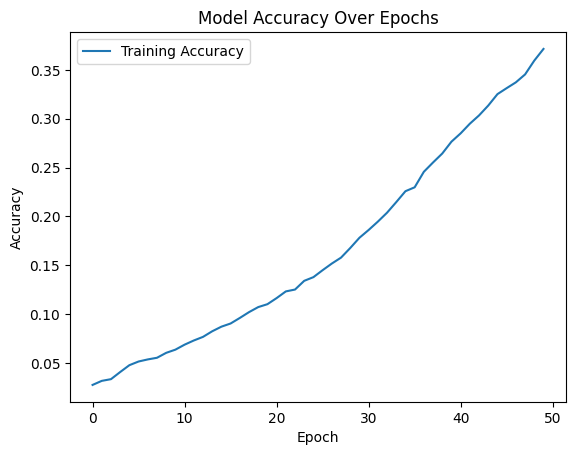

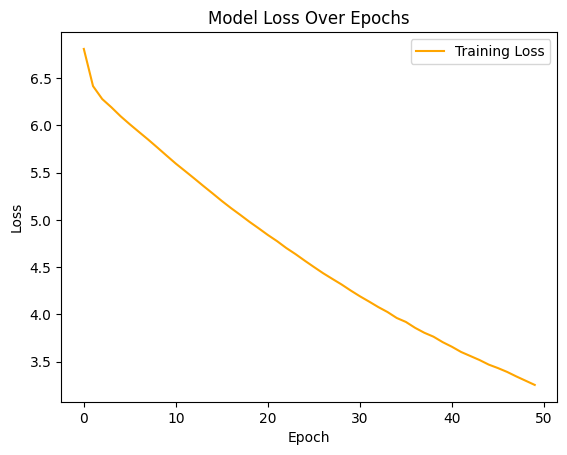

In [29]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [33]:
seed_text = 'When I go to the shopping mall'
next_words = 5

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [34]:
# Text generation loop based on next_words and seed_text
for _ in range(next_words):
    # Convert current seed_text into sequence of tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequence so it matches the model's input shape
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    # Predict next word (returns probability distribution)
    predicted = model.predict(token_list, verbose=0)
    # Get the index of the word with the highest probability
    predicted_index = np.argmax(predicted)

    # Map the index back to the word
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    # Append the predicted word to the seed text
    seed_text += " " + output_word

# Print the full text with generated content
print("\nGenerated Text:\n")
print(seed_text)



Generated Text:

When I go to the shopping mall main of light hour clearer


Experiment with at least 3 different seed_text strings and see what happens!

In [35]:
# List of different seed_text examples
seed_texts = [
    "We love to play football on the beach when",
    "He had an accident yesterday night, apparently",
    "I dont thing this model works very well but"
]

next_words = 20  # Number of words to generate for each seed_text

# Loop over each seed_text
for idx, seed_text in enumerate(seed_texts, 1):
    original_seed = seed_text  # Keep original seed for display
    print(f"\n--- Example {idx}: Seed Text ---\n{original_seed}\n")

    # Generate words
    for _ in range(next_words):
        # Tokenize and pad
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        # Predict next word
        predicted = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted)
        # Map back to word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        # Append word
        seed_text += " " + output_word

    # Print generated text
    print(f"--- Generated Text ---\n{seed_text}\n")



--- Example 1: Seed Text ---
We love to play football on the beach when

--- Generated Text ---
We love to play football on the beach when of thee old store tied dearer prove write old part view halt life spent that that slain thee for you


--- Example 2: Seed Text ---
He had an accident yesterday night, apparently

--- Generated Text ---
He had an accident yesterday night, apparently which me here more more nearly bring change your sight ' lies lies free prove thee rare twain but slain


--- Example 3: Seed Text ---
I dont thing this model works very well but

--- Generated Text ---
I dont thing this model works very well but harvest account new kind ' back away i lie her life alone eyes me thought thee well doth belong twain

